## 1. Load libraries

In [1]:
import pandas as pd

In [2]:
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data
import torch_geometric.transforms as transforms

## 2. Read spatial data: Nigeria DHS 20-21

In [3]:
import geopandas as gpd
df = gpd.read_file("../data/nga_dhs20-21.shp")
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")
#gdf = gdf.to_crs("EPSG:32617")

In [4]:
gdf.geometry.unique()

<GeometryArray>
[ <POINT (8.507 7.72)>, <POINT (8.552 7.718)>, <POINT (8.991 7.347)>,
   <POINT (8.15 7.21)>, <POINT (8.408 6.881)>, <POINT (7.951 7.805)>,
 <POINT (7.838 7.595)>, <POINT (8.125 7.605)>, <POINT (8.503 7.689)>,
 <POINT (8.582 7.845)>,
 ...
  <POINT (3.19 8.318)>, <POINT (4.022 7.953)>, <POINT (4.191 8.202)>,
 <POINT (4.431 7.977)>,  <POINT (4.104 7.85)>, <POINT (3.588 7.828)>,
  <POINT (3.343 8.05)>, <POINT (3.018 7.948)>, <POINT (3.291 7.341)>,
 <POINT (3.948 7.786)>]
Length: 1383, dtype: geometry

In [5]:
centroids = np.array([(point.x, point.y) for point in df.geometry.centroid])
centroids

C:\Users\girel\AppData\Local\Temp\ipykernel_32440\4188193525.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.array([(point.x, point.y) for point in df.geometry.centroid])


array([[8.506936, 7.720049],
       [8.552142, 7.717922],
       [8.991185, 7.346602],
       ...,
       [3.017661, 7.947632],
       [3.291019, 7.341286],
       [3.948039, 7.785664]])

## 3. Build distance matrix

We build a proximity matrix between the clusters

In [6]:
from scipy.spatial.distance import cdist
distance_matrix = cdist(np.unique(centroids, axis = 0), np.unique(centroids, axis = 0), 'euclidean')

In [7]:
distance_matrix

array([[ 0.        ,  7.90917123,  7.11335248, ..., 16.77679502,
        17.73958348, 18.81761545],
       [ 7.90917123,  0.        ,  0.8931784 , ..., 10.93767371,
        11.43550126, 12.22038214],
       [ 7.11335248,  0.8931784 ,  0.        , ..., 11.1203557 ,
        11.72264204, 12.58043899],
       ...,
       [16.77679502, 10.93767371, 11.1203557 , ...,  0.        ,
         1.47642768,  2.79842185],
       [17.73958348, 11.43550126, 11.72264204, ...,  1.47642768,
         0.        ,  1.33305874],
       [18.81761545, 12.22038214, 12.58043899, ...,  2.79842185,
         1.33305874,  0.        ]])

In [8]:
max_distance = np.max(distance_matrix)
max_distance

18.817615452436154

In [9]:
weighted_proximity_matrix = np.zeros_like(distance_matrix)
for i in range(len(distance_matrix)):
    for j in range(len(distance_matrix)):
        proximity = (max_distance - distance_matrix[i, j]) / max_distance
        proximity = max(0, proximity)
        weighted_proximity_matrix[i, j] = proximity

In [10]:
print(weighted_proximity_matrix.min(),weighted_proximity_matrix.max())

0.0 1.0


In [11]:
threshold = 0.99
weighted_proximity_matrix[weighted_proximity_matrix < threshold] = 0

In [12]:
weighted_proximity_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [13]:
weighted_proximity_matrix[np.diag_indices_from(weighted_proximity_matrix)] = 0

## 4. Transform data to tensor

Create torch_geometric.data.Data object

Transform proximity matrix to tensor and create edges 

In [14]:
adj_matrix = torch.tensor(weighted_proximity_matrix)

In [15]:
edges = adj_matrix.nonzero().t().contiguous()

In [16]:
edges

tensor([[   2,    2,    2,  ..., 1380, 1380, 1380],
        [   4,    5,    6,  ..., 1375, 1376, 1377]])

Get edge attributes (given by proximity of clusters)

In [17]:
edge_attr = []
for i in range(edges.size(1)):
    edge_attr.append([adj_matrix[edges[0][i], edges[1][0]]])

edge_attr = torch.tensor(edge_attr, dtype=torch.float)

Prepare features

In [18]:
gdf.columns

Index(['dhsclst', 'd_cm', 'd_nutr', 'd_satt', 'd_educ', 'd_elct', 'd_wtr',
       'd_sani', 'd_hsg', 'd_ckfl', 'd_asst', 'score', 'sexfeml', 'sexmale',
       'agc70_4', 'a710_14', 'a715_17', 'a718_59', 'agc75_9', 'agc760_',
       'arearrl', 'arearbn', 'reginAb', 'rgnAdmw', 'rgnAk_I', 'rgnAnmb',
       'regnBch', 'rgnByls', 'reginBn', 'regnBrn', 'rgnCr_R', 'regnDlt',
       'rgnEbny', 'reginEd', 'regnEkt', 'regnEng', 'regnFCT', 'regnGmb',
       'reginIm', 'regnJgw', 'regnKdn', 'reginKn', 'rgnKtsn', 'regnKbb',
       'reginKg', 'regnKwr', 'regnLgs', 'rgnNsrw', 'regnNgr', 'regnOgn',
       'regnOnd', 'regnOsn', 'reginOy', 'regnPlt', 'rgnRvrs', 'regnSkt',
       'regnTrb', 'reginYb', 'rgnZmfr', 'hdshpf_', 'hdshpm_', 'categry',
       'geometry'],
      dtype='object')

In [19]:
features = list(gdf.columns[list(range(1, gdf.shape[1]-4))])

In [20]:
# Avoid multicollineality
for i in ['sexmale','agc760_','arearrl','reginAb','score']:#,'hdshpm_']:#,
         #'d_cm', 'd_nutr', 'd_satt', 'd_educ']:
    features.remove(i)

In [50]:
print(features)

['d_cm', 'd_nutr', 'd_satt', 'd_educ', 'd_elct', 'd_wtr', 'd_sani', 'd_hsg', 'd_ckfl', 'd_asst', 'sexfeml', 'agc70_4', 'a710_14', 'a715_17', 'a718_59', 'agc75_9', 'arearbn', 'rgnAdmw', 'rgnAk_I', 'rgnAnmb', 'regnBch', 'rgnByls', 'reginBn', 'regnBrn', 'rgnCr_R', 'regnDlt', 'rgnEbny', 'reginEd', 'regnEkt', 'regnEng', 'regnFCT', 'regnGmb', 'reginIm', 'regnJgw', 'regnKdn', 'reginKn', 'rgnKtsn', 'regnKbb', 'reginKg', 'regnKwr', 'regnLgs', 'rgnNsrw', 'regnNgr', 'regnOgn', 'regnOnd', 'regnOsn', 'reginOy', 'regnPlt', 'rgnRvrs', 'regnSkt', 'regnTrb', 'reginYb', 'rgnZmfr']


In [21]:
x = torch.tensor(np.array(gdf[features]))

Target variable

In [22]:
task = "reg"

In [23]:
if task == "reg":
    target_tensor = torch.tensor(gdf['score'], dtype=torch.float)
else: 
    target = pd.Categorical(gdf['categry'])
    numerical_categories = target.codes
    print(np.unique(numerical_categories))
    target_tensor = torch.tensor(numerical_categories, dtype=torch.long) 
target_tensor

tensor([0.0804, 0.0678, 0.0451,  ..., 0.1570, 0.5354, 0.1026])

In [24]:
graph = torch_geometric.data.Data(x=x, edge_index=edges, edge_attr = edge_attr,y=target_tensor)
graph

Data(x=[1389, 53], edge_index=[2, 8914], edge_attr=[8914, 1], y=[1389])

<BarContainer object of 46 artists>

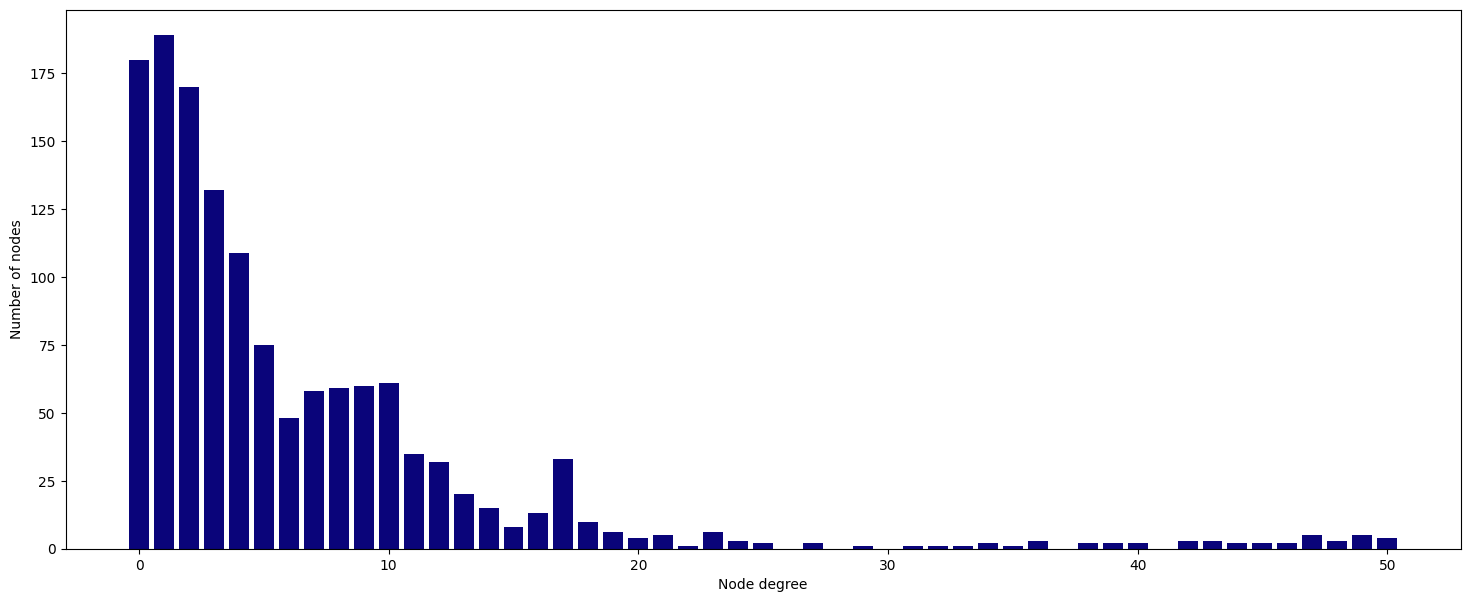

In [25]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(graph.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

In [26]:
from torch_geometric.loader import DataLoader

In [27]:
# Determine the number of nodes
num_nodes = graph.num_nodes
num_nodes

1389

In [28]:
# Calculate the sizes of the train, validation, and test sets
train_size = int(0.8 * num_nodes)
val_size = int(0.1 * num_nodes)
test_size = num_nodes - train_size - val_size
print(train_size, val_size, test_size)

1111 138 140


In [29]:
# Create random permutations of node indices
# Set the random seed
seed = 91218
torch.manual_seed(seed)
perm = torch.randperm(num_nodes)

# Create boolean masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[perm[:train_size]] = True
val_mask[perm[train_size:train_size + val_size]] = True
test_mask[perm[train_size + val_size:]] = True

# Add the masks to the graph object
graph.train_mask = train_mask
graph.val_mask = val_mask
graph.test_mask = test_mask

print(graph) #now the graph contains the masks.

Data(x=[1389, 53], edge_index=[2, 8914], edge_attr=[8914, 1], y=[1389], train_mask=[1389], val_mask=[1389], test_mask=[1389])


In [30]:
from torch_geometric.utils import subgraph
train_nodes = torch.where(train_mask)[0]
sub_edge_index, _ = subgraph(train_mask, graph.edge_index, relabel_nodes=True)
train_x = graph.x[train_nodes]
train_y = graph.y[train_nodes]
train_data = torch_geometric.data.Data(x=train_x, y=train_y, edge_index=sub_edge_index)
train_loader = torch_geometric.loader.DataLoader([train_data], batch_size=int(train_size//20), shuffle=True)

val_nodes = torch.where(val_mask)[0]
sub_edge_index, _ = subgraph(val_mask, graph.edge_index, relabel_nodes=True)
val_x = graph.x[val_nodes]
val_y = graph.y[val_nodes]
val_data = torch_geometric.data.Data(x=val_x, y=val_y, edge_index=sub_edge_index)
val_loader = torch_geometric.loader.DataLoader([val_data], batch_size=val_size)

test_nodes = torch.where(test_mask)[0]
sub_edge_index, _ = subgraph(test_mask, graph.edge_index, relabel_nodes=True)
test_x = graph.x[test_nodes]
test_y = graph.y[test_nodes]
test_data = torch_geometric.data.Data(x=test_x, y=test_y, edge_index=sub_edge_index)
test_loader = torch_geometric.loader.DataLoader([test_data], batch_size=test_size)

## 5. Prepare models

In [31]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, GATConv

In [32]:
class GAT(torch.nn.Module):
    """
    Graph Attention network
    """
    def __init__(self, dim_in, dim_h, dim_out, n_heads):
        super(GAT, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads = n_heads)
        self.norm1 = torch.nn.LayerNorm(dim_h * n_heads)
        self.gat2 = GATv2Conv(dim_h*n_heads, dim_out, heads = 1)
        self.norm2 = torch.nn.LayerNorm(16*n_heads)
        self.gat3 = GATv2Conv(n_heads*n_heads, 16, heads = 1)

    def forward(self, x, edge_index):
        x1 = F.dropout(x, p = 0.7, training = self.training)
        x = self.gat1(x1, edge_index)
        x = self.norm1(x)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gat2(x, edge_index)
        return x, F.log_softmax(x, dim=1)

In [33]:
dim_in = graph.x.size(1)  
dim_h = 32
if task == "reg":
    dim_out = 1
else:
    dim_out = len(graph.y.unique()) # Number of classes 
n_heads = 16

# Create an instance of your GAT model
model = GAT(dim_in, dim_h, dim_out, n_heads)
untrained = GAT(dim_in, dim_h, dim_out, n_heads)

In [34]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),weight_decay=5e-4)
if task == "reg":
    criterion = torch.nn.MSELoss()
else:
    criterion = torch.nn.CrossEntropyLoss()
n_epochs = 500

In [35]:
print(model)

GAT(
  (gat1): GATv2Conv(53, 32, heads=16)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (gat2): GATv2Conv(512, 1, heads=1)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (gat3): GATv2Conv(256, 16, heads=1)
  (norm3): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (linear1): Linear(in_features=16, out_features=25, bias=True)
  (linear2): Linear(in_features=25, out_features=1, bias=True)
)


In [36]:
def train(model, graph, optimizer, criterion):
    model.train()
    total_loss = 0
    num_batches = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out, log_probs = model(batch.x.float(), batch.edge_index)
        if task == "reg":
            y_pred = out
        else: 
            y_pred = log_probs
        y_true = batch.y.view(-1, 1)
        loss = criterion(y_pred, y_true) #only compute the loss on the train nodes.
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    return total_loss / num_batches

def test(model, graph, criterion, loader): #mask parameter added.
    model.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in loader:
            out, log_probs = model(batch.x.float(), batch.edge_index)
            if task == "reg":
                y_pred = out
            else: 
                y_pred = log_probs
            y_true = batch.y.view(-1, 1)
            loss = criterion(y_pred, y_true) 
            total_loss += loss.item()
            num_batches += 1
    return total_loss / num_batches

# Training loop
train_losses = []  # List to store losses
val_losses = []
test_losses = []
epochs_list = [] # List to store epoch numbers.
for epoch in range(n_epochs):
    train_loss = train(model, graph, optimizer, criterion)
    val_loss = test(model, graph, criterion, val_loader) #pass the validation mask
    test_loss = test(model, graph, criterion, test_loader) #pass the test mask
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    epochs_list.append(epoch + 1)
    print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/500, Train Loss: 1.8337, Val Loss: 0.9438, Test Loss: 1.1203
Epoch 2/500, Train Loss: 1.3458, Val Loss: 0.6637, Test Loss: 0.7999
Epoch 3/500, Train Loss: 1.3302, Val Loss: 0.2949, Test Loss: 0.3338
Epoch 4/500, Train Loss: 0.8121, Val Loss: 0.3862, Test Loss: 0.3620
Epoch 5/500, Train Loss: 0.7629, Val Loss: 0.6040, Test Loss: 0.5705
Epoch 6/500, Train Loss: 0.7982, Val Loss: 0.5152, Test Loss: 0.4919
Epoch 7/500, Train Loss: 0.7179, Val Loss: 0.2531, Test Loss: 0.2348
Epoch 8/500, Train Loss: 0.5702, Val Loss: 0.1175, Test Loss: 0.1005
Epoch 9/500, Train Loss: 0.5091, Val Loss: 0.1347, Test Loss: 0.1190
Epoch 10/500, Train Loss: 0.6930, Val Loss: 0.1717, Test Loss: 0.1561
Epoch 11/500, Train Loss: 0.6000, Val Loss: 0.1607, Test Loss: 0.1460
Epoch 12/500, Train Loss: 0.5651, Val Loss: 0.1302, Test Loss: 0.1179
Epoch 13/500, Train Loss: 0.5601, Val Loss: 0.1216, Test Loss: 0.1124
Epoch 14/500, Train Loss: 0.4967, Val Loss: 0.1341, Test Loss: 0.1280
Epoch 15/500, Train Loss: 0.5

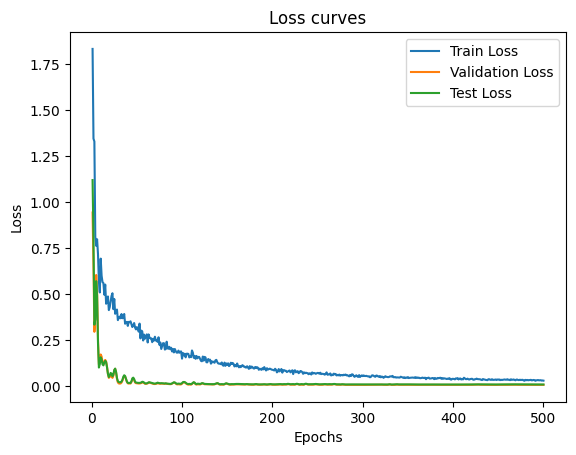

In [44]:
# Plotting the loss
plt.plot(epochs_list, train_losses, label = "Train Loss")
plt.plot(epochs_list, val_losses, label = "Validation Loss")
plt.plot(epochs_list, test_losses, label = "Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss curves')
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error, r2_score
model.eval()
with torch.no_grad():
    for batch in test_loader:
        out, log_probs = model(batch.x.float(), batch.edge_index)
        ypred_gnn = out
        y_true = batch.y.view(-1, 1)
        val_mse = mean_squared_error(y_true, ypred_gnn)
        val_r2 = r2_score(y_true, ypred_gnn)
print(val_mse, val_r2)

0.008391563 0.763477451733516


In [48]:
sum(ypred_gnn < 0)

tensor([0])

In [49]:
from sklearn.ensemble import RandomForestRegressor

def extract_node_features_and_targets(loader):
    """
    Extracts node features and regression targets from a PyTorch Geometric DataLoader.

    Args:
        loader: PyTorch Geometric DataLoader.

    Returns:
        features (numpy.ndarray): Node features.
        targets (numpy.ndarray): Regression targets.
    """
    all_features = []
    all_targets = []
    for batch in loader:
        all_features.append(batch.x.numpy())
        all_targets.append(batch.y.numpy())
    features = np.concatenate(all_features, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    return features, targets.reshape(-1) #Reshape to 1D array

def train_and_evaluate_random_forest(train_loader, val_loader, test_loader):
    """
    Trains and evaluates a Random Forest Regressor using extracted node features.

    Args:
        train_loader: PyTorch Geometric DataLoader for training.
        val_loader: PyTorch Geometric DataLoader for validation.
        test_loader: PyTorch Geometric DataLoader for testing.
    """
    # Extract features and targets
    train_features, train_targets = extract_node_features_and_targets(train_loader)
    val_features, val_targets = extract_node_features_and_targets(val_loader)
    test_features, test_targets = extract_node_features_and_targets(test_loader)

    # Initialize and train the Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=91218)  # Adjust parameters as needed
    rf.fit(train_features, train_targets)

    # Evaluate on validation set (for hyperparameter tuning if needed)
    val_predictions = rf.predict(val_features)
    val_mse = mean_squared_error(val_targets, val_predictions)
    val_r2 = r2_score(val_targets, val_predictions)
    print(f"Random Forest Validation MSE: {val_mse:.4f}")
    print(f"Random Forest Validation R2: {val_r2:.4f}")

    # Evaluate on test set
    test_predictions = rf.predict(test_features)
    test_mse = mean_squared_error(test_targets, test_predictions)
    test_r2 = r2_score(test_targets, test_predictions)
    print(f"Random Forest Test MSE: {test_mse:.4f}")
    print(f"Random Forest Test R2: {test_r2:.4f}")

    return test_mse, test_r2, test_predictions

# Example Usage (assuming you have train_loader, val_loader, test_loader)
# train_loader, val_loader, test_loader are pytorch geometric dataloaders
# Example:
train_mse, train_r2, ypred = train_and_evaluate_random_forest(train_loader, val_loader, test_loader)

Random Forest Validation MSE: 0.0005
Random Forest Validation R2: 0.9828
Random Forest Test MSE: 0.0005
Random Forest Test R2: 0.9855


In [41]:
np.any(ypred < 0)

False

In [ ]:
if task == "reg":
    break

In [42]:
from sklearn.manifold import TSNE

In [43]:
# Get embeddings
h, _ = untrained(graph.x.float(), graph.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

unique_labels = np.unique(graph.y)
labels = ['Moderate Poor', 'Non-vulnerable', 'Severe Poor', 'Vulnerable']

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
# Scatter plot with different colors for each class
for label in unique_labels:
    indices = graph.y == label
    plt.scatter(tsne[indices, 0], tsne[indices, 1], s=20, label=labels[label])
    # Add legend
plt.legend(title="Class Labels", loc="upper right")
plt.show()

ValueError: n_components=2 must be between 1 and min(n_samples, n_features)=1 with svd_solver='randomized'

In [ ]:
h, _ = model(graph.x.float(), graph.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

unique_labels = np.unique(graph.y)
labels = ['Moderate Poor', 'Non-vulnerable', 'Severe Poor', 'Vulnerable']

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
# Scatter plot with different colors for each class
for label in unique_labels:
    indices = graph.y == label
    plt.scatter(tsne[indices, 0], tsne[indices, 1], s=20, label=labels[label])
# Add legend
plt.legend(title="Class Labels", loc="upper right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
model.eval()
output = model(graph.x.float(), graph.edge_index)
i, y_pred = output[1].max(1)
y_true = graph.y
cm = confusion_matrix(graph.y, y_pred)

In [ ]:
plt.figure(figsize=(len(labels),len(labels)))
cm_prop = cm.astype('float') / cm.sum(axis=1)
sns.heatmap(cm_prop, annot = True, xticklabels=labels, yticklabels=labels)
plt.show()

In [ ]:
plt.figure(figsize=(len(labels),len(labels)))
sns.heatmap(cm.astype('int'), annot = True, xticklabels=labels, yticklabels=labels)
plt.show()